In [1]:
import os
import cv2
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import itertools
from sklearn.cluster import MeanShift
from scipy.spatial.distance import cdist

In [2]:
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew
from matplotlib import pyplot as plt

In [3]:
def deskew(image):
    co_ords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(co_ords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC,
    borderMode=cv2.BORDER_REPLICATE)
    return rotated

def remove_noise(img):
    kernel = np.ones((2,2),np.uint8)
    img = cv2.dilate(img, kernel, iterations=1) 
    kernel = np.ones((1,1),np.uint8)
    img = cv2.erode(img, kernel, iterations=1) 
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE,kernel) 
    img = cv2.medianBlur(img,3)
    return img

def preprocess_img(image,size=(600,800)):   
    image = cv2.resize(image,size,interpolation = cv2.INTER_LINEAR)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # img_resized = cv2.resize(img, fx=scale[0], fy=scale[1],,dsize=(0,0), interpolation=cv2.INTER_CUBIC)
    # imgThresh = cv2.ximgproc.niBlackThreshold(img,maxValue=128,type=cv2.THRESH_BINARY,blockSize=3,k=0.2)
    # imgThresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)[1]
    imgThresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,129,4)
    img_denoise = cv2.fastNlMeansDenoising(imgThresh, None, 10, 7, 15)
    # kernel = np.ones((2,2),np.uint8)
    # img_erosion = cv2.erode(imgThresh, kernel, iterations=1) 
    return image,img_denoise

    # img_dilation = cv2.dilate(img_erosion, kernel, iterations=1) 
    '''
    img = deskew(img)
    imgThresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,81,4)
    imgThresh = cv2.ximgproc.niBlackThreshold(img,maxValue=255,type=cv2.THRESH_BINARY,blockSize=5,k=-0.2)
    imgThresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)[1]
    
    
    img_dilation = cv2.dilate(imgThresh, kernel, iterations=1) 
    norm_img = np.zeros((image.shape[0], image.shape[1]))
    img = cv2.normalize(image, norm_img, 0, 255, cv2.NORM_MINMAX)
    '''    

def generate_stats(totalLabels,stats, centroids):
    '''
    totalLabels,stats, centroids : cv2 connectedComponentsWithStats outputs
    '''
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

def filter_components(df,min_ar_thresh=None,max_ar_thresh=None):
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    if min_ar_thresh and max_ar_thresh:
        df = df[(df['aspect_ratio'] > min_ar_thresh) & (df['aspect_ratio'] < max_ar_thresh)]
    return df


def plot_conn_components(image,k=1,query=False):
    '''plot stats components identified '''
    image,imgThresh = preprocess_img(image)
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh,4,cv2.CV_32S) # type: ignore #4 is for connectivity
    df = generate_stats(totalLabels,stats, centroid)
    df = filter_components(df)
    output = image.copy() 
    for comp in df['label_id'].values:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.title('original')
    plt.imshow(image)
    plt.show()
    plt.title('thresholded')
    plt.imshow(imgThresh,cmap='gray')
    plt.show()
    plt.title('denoised')
    plt.imshow(imgThresh,cmap='gray')
    plt.show()
    plt.title('components')
    plt.imshow(output)
    plt.show()
    return df.sort_values(by='area'),imgThresh


In [ ]:
# 1. why is not working
# 2. save output and check after each step.
# remove smearing, binarization. full understanding
#rescale to a standard size

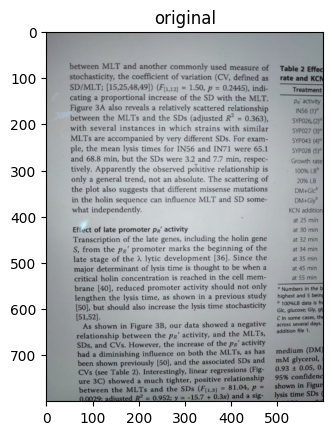

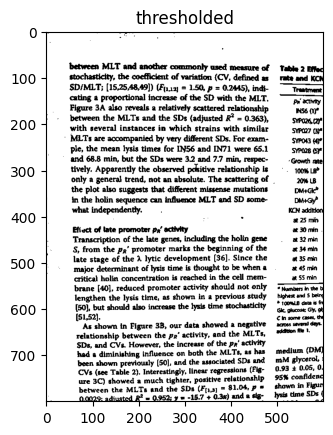

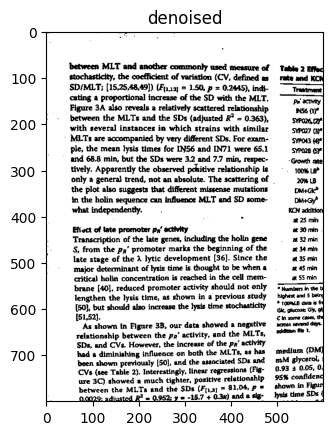

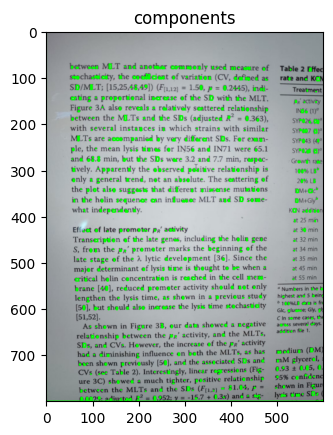

label_id  left  top  width  height    area  centroid_x  centroid_y  \
191       192   223  209      1       1       1  223.000000  209.000000   
472       473   260  449      1       1       1  260.000000  449.000000   
475       476   390  448      1       1       1  390.000000  448.000000   
250       251   438  254      1       1       1  438.000000  254.000000   
249       250   423  254      1       1       1  423.000000  254.000000   
..        ...   ...  ...    ...     ...     ...         ...         ...   
85         86    65  117      5       9      38   66.736842  120.894737   
102       103   354  140      5       9      39  355.871795  143.615385   
210       211   379  228      5       9      39  380.743590  232.000000   
0           1     0    0    600     800   94699  311.097002  425.193761   
1           2     0    0    600     800  379835  296.530080  393.178280   

     aspect_ratio  
191          1.00  
472          1.00  
475          1.00  
250          1.00  
249          1.00  
..            ...  
85           0.56  
102          0.56  
210          0.56  
0            0.75  
1            0.75  

[913 rows x 9 columns]

In [4]:
image = cv2.imread("./../../data/queries/2.jpeg")
df, img = plot_conn_components(image,query=True)
df

<Axes: >

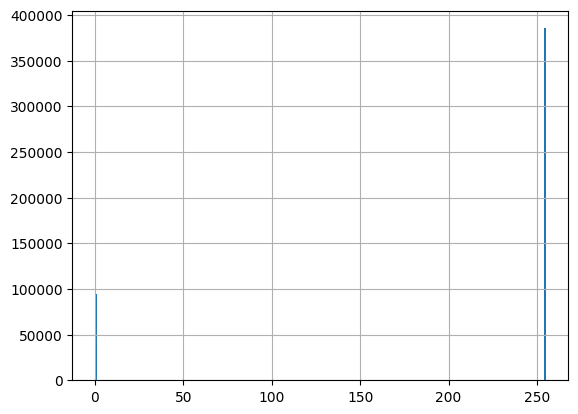

In [5]:
pd.Series(img.flatten()).hist(bins=255)

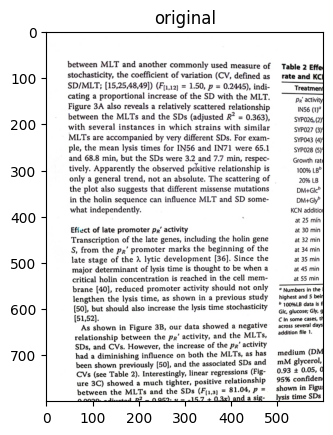

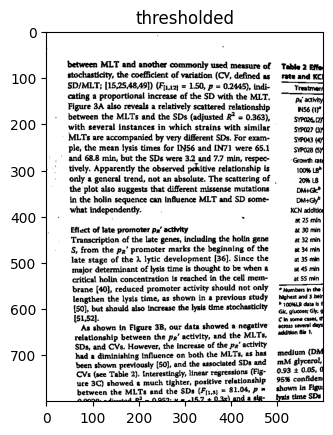

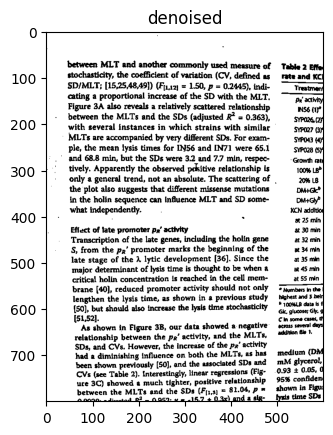

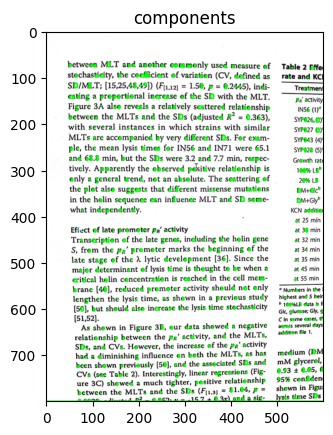

(     label_id  left  top  width  height    area  centroid_x  centroid_y  \
 399       400   213  429      1       1       1  213.000000  429.000000   
 598       599   340  600      1       1       1  340.000000  600.000000   
 599       600   392  600      1       1       1  392.000000  600.000000   
 600       601   132  603      1       1       1  132.000000  603.000000   
 245       246   464  274      1       1       1  464.000000  274.000000   
 ..        ...   ...  ...    ...     ...     ...         ...         ...   
 82         83   355  136      6       9      42  356.976190  140.285714   
 182       183   380  226      6       9      42  381.952381  229.904762   
 140       141   288  180      6      10      44  290.136364  184.500000   
 0           1     0    0    600     800   92398  311.396286  427.286608   
 1           2     0    0    600     800  382514  296.521986  392.775328   
 
      aspect_ratio  
 399          1.00  
 598          1.00  
 599          1.00  
 6

In [6]:
q12 = cv2.imread("./../../data/queries/2_CS.jpeg")
plot_conn_components(q12)

(<matplotlib.image.AxesImage at 0x7f94e8096210>, (1676, 1264, 3))

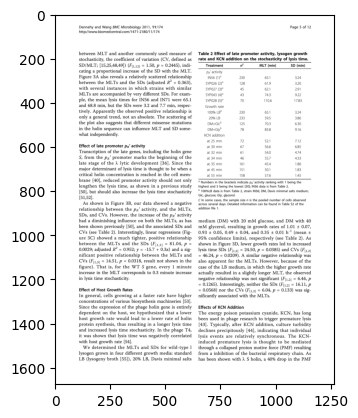

In [33]:
doc_img = cv2.imread('./../../data/docs/1.png')
plt.imshow(doc_img),doc_img.shape

In [11]:
def extract_ROI(image):
    
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, 0, -1)

    # Dilate to merge into a single contour
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,30))
    dilate = cv2.dilate(thresh, vertical_kernel, iterations=3)

    # Find contours, sort for largest contour and extract ROI
    cnts, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:-1]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        # cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 4)
        ROI = image[y:y+h, x:x+w]
        break
    return ROI
# plt.imshow(extract_ROI(q4))

def deskew(image):
    grayscale = rgb2gray(image)
    angle = determine_skew(grayscale)
    print("angle:", angle)
    rotated = (rotate(image, angle, resize=True) * 255).astype(np.uint8)
    return rotated
# plt.imshow(deskew(extract_ROI(q4)))

def normalize_image(image, target_width=600, target_height=800):
    original_height, original_width = image.shape[:2]
    scale_x = target_width / original_width
    scale_y = target_height / original_height
    scaled_image = cv2.resize(image, (target_width, target_height))
    return scaled_image
# plt.imshow(normalize_image(q4))

def preprocess(img):
    img = extract_ROI(img)
    img = deskew(img)
    img= normalize_image(img)
    return img

angle: 0.0


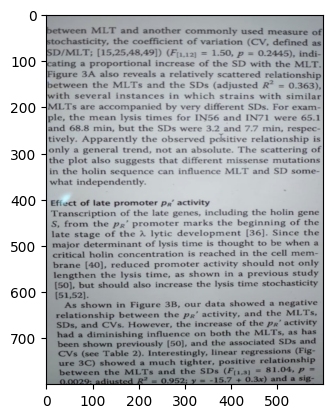

In [13]:
plt.imshow(preprocess(image),cmap='gray')

angle: 0.0


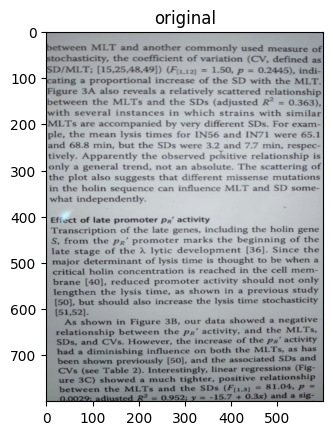

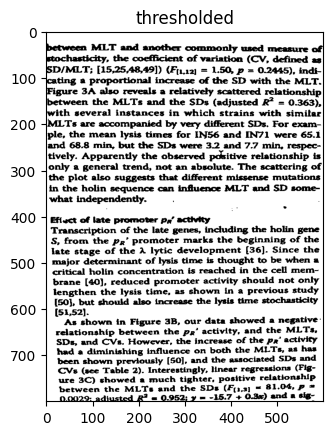

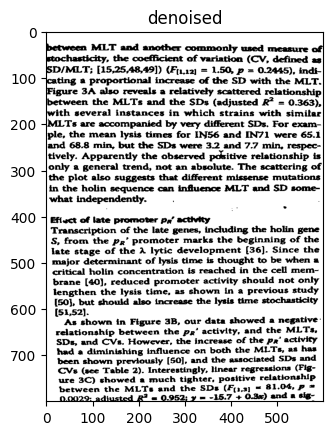

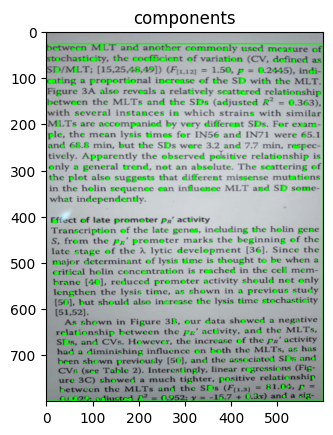

(     label_id  left  top  width  height    area  centroid_x  centroid_y  \
 719       720   474  732      1       1       1  474.000000  732.000000   
 379       380   191  340      1       1       1  191.000000  340.000000   
 631       632   573  648      1       1       1  573.000000  648.000000   
 708       709   435  729      1       1       1  435.000000  729.000000   
 377       378   144  340      1       1       1  144.000000  340.000000   
 ..        ...   ...  ...    ...     ...     ...         ...         ...   
 198       199   454  196      7       9      55  456.672727  200.000000   
 249       250   259  242      7      10      56  261.500000  246.500000   
 158       159   329  149      7       9      57  331.719298  153.000000   
 0           1     0   27    598     773  114233  292.661753  400.695228   
 1           2     0    0    600     800  359331  301.926850  399.844052   
 
      aspect_ratio  
 719          1.00  
 379          1.00  
 631          1.00  
 7

In [12]:
plot_conn_components(preprocess(image))

In [14]:
from skimage.filters import threshold_otsu, threshold_niblack,threshold_sauvola


In [15]:
window_size = 25
k = 0.2
thresh_niblack = threshold_niblack(image, window_size=window_size, k=k)

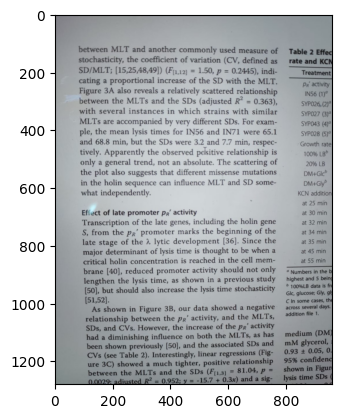

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


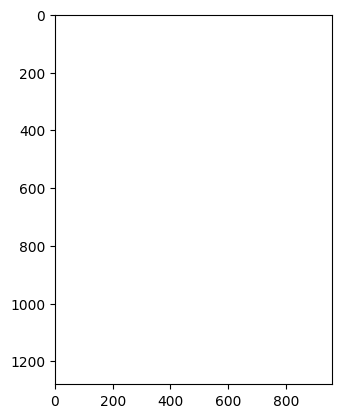

In [17]:
plt.imshow(image,cmap='gray')
plt.show()
plt.imshow(thresh_niblack,cmap='gray')
plt.show()

In [34]:
def preprocess_opening(image,size=(1200,1600)):
    image = cv2.resize(image,size,interpolation = cv2.INTER_LINEAR)
    img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    # thresh = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)[1]
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,129,4)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    result = 255 - opening

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    morph = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)


    plt.title('original')
    plt.imshow(image)
    plt.show()
    plt.title('thresholded')
    plt.imshow(thresh,cmap='gray')
    plt.show()
    plt.title('opening')
    plt.imshow(opening,cmap='gray')
    plt.show()
    plt.title('inverse opening')
    plt.imshow(result,cmap='gray')
    plt.show()

    return result,image

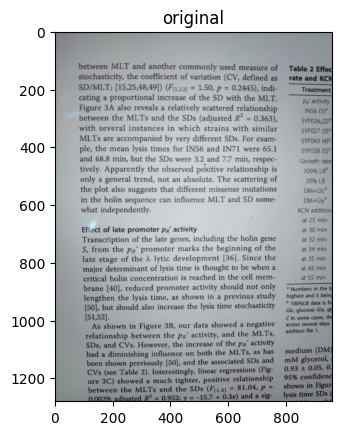

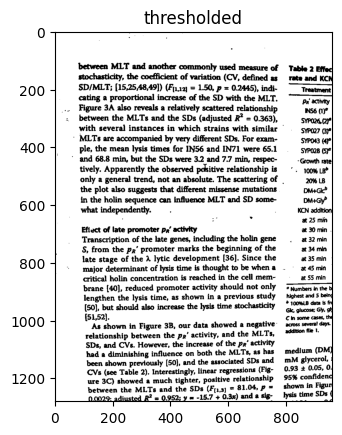

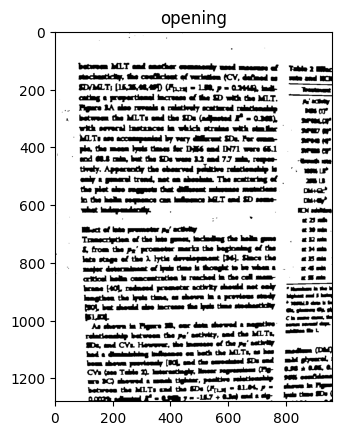

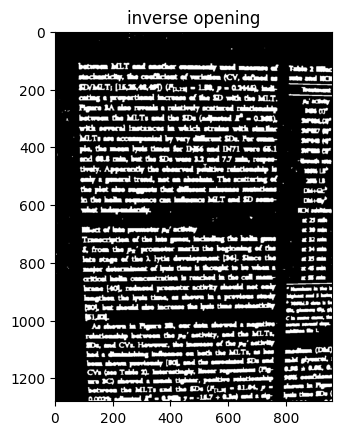

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [23]:
preprocess_opening(image)

In [30]:
def plot_conn_components(image):
    imgThresh,image = preprocess_opening(image)
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh,4,cv2.CV_32S) # type: ignore #4 is for connectivity
    df = generate_stats(totalLabels,stats, centroid)
    df = filter_components(df,1,10)
    output = image.copy() 
    for comp in df['label_id'].values:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.title('components')
    plt.imshow(output)
    plt.show()

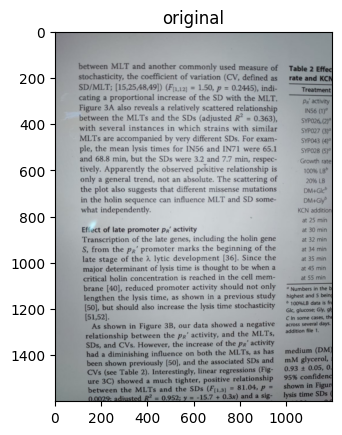

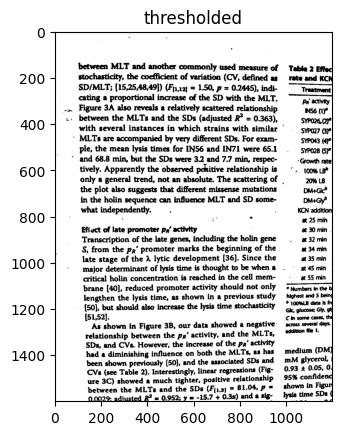

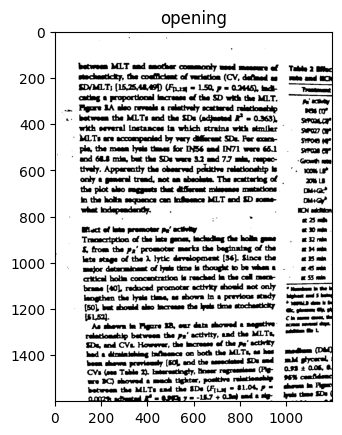

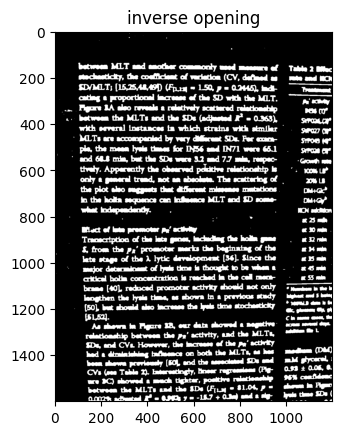

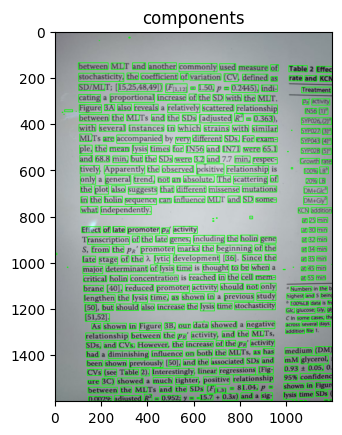

In [35]:
plot_conn_components(image=image)

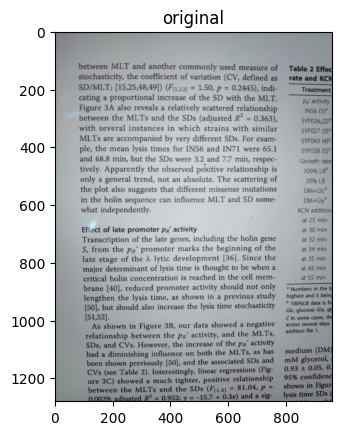

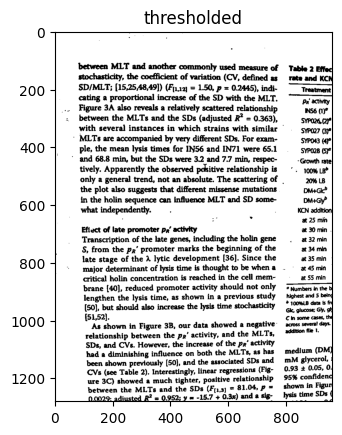

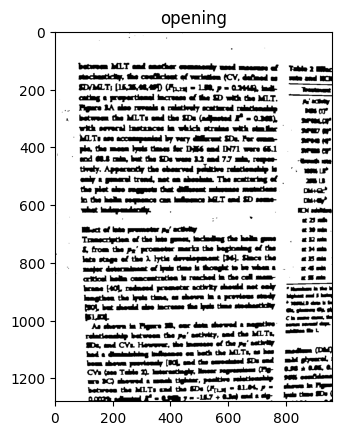

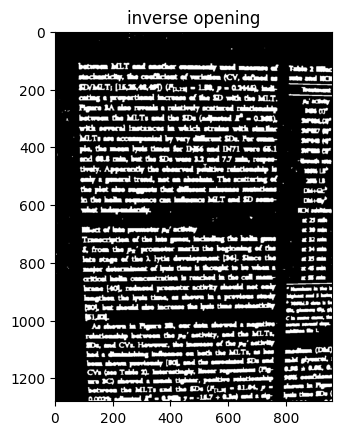

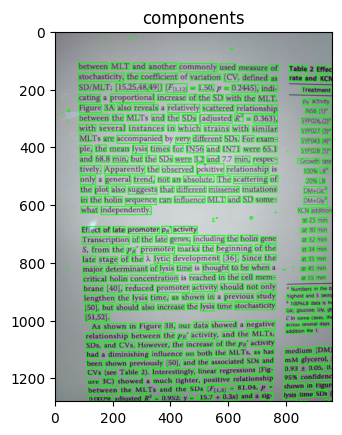

In [25]:
plot_conn_components(image=image)

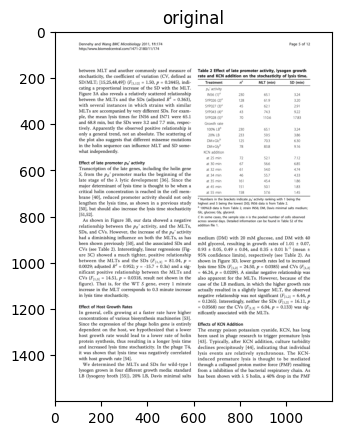

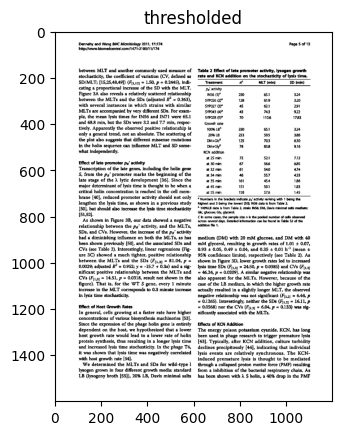

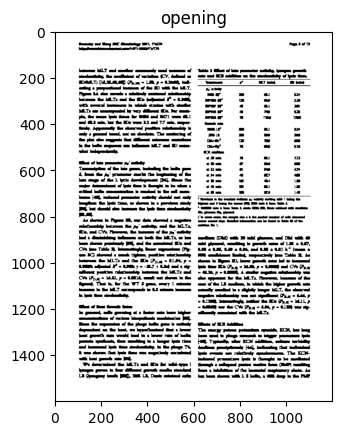

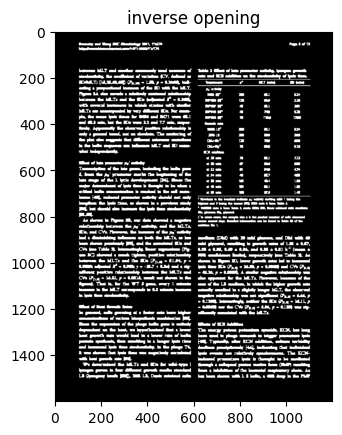

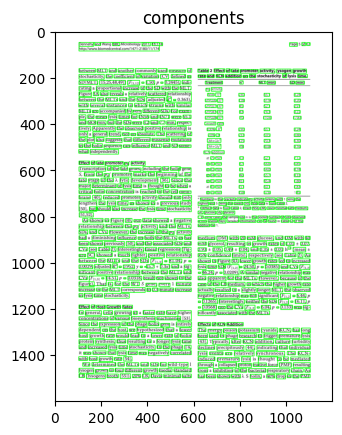

In [36]:
plot_conn_components(image=doc_img)

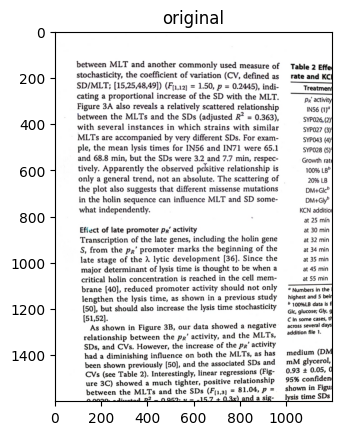

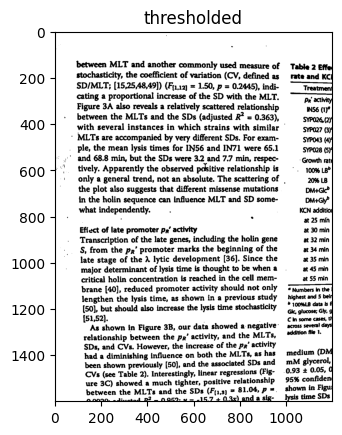

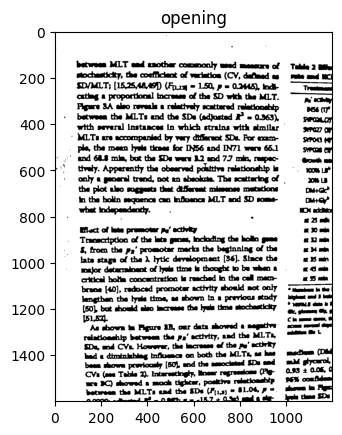

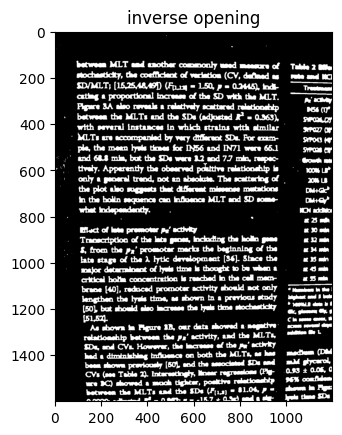

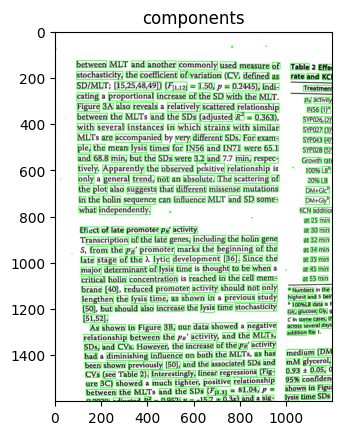

In [37]:
q12 = cv2.imread("./../../data/queries/2_CS.jpeg")
plot_conn_components(image=q12)

In [ ]:
def is_contour_bad(c):
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# the contour is 'bad' if it is not a rectangle
	return not len(approx) == 4